In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import scanpy as sc

In [3]:
from pca import LowRank, n2s_low_rank

Paul dataset with PC regression and PCA.

In [4]:
paul = sc.read('/Users/josh/src/noise2self-single-cell/data/paul/paul.h5ad')

Optimal rank: 7


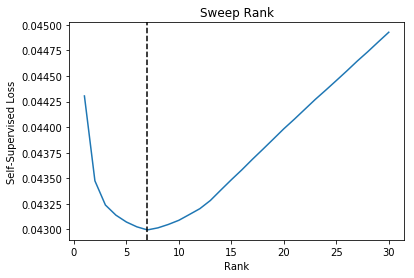

In [14]:
denoised_adata = n2s_low_rank(paul, regression=False)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


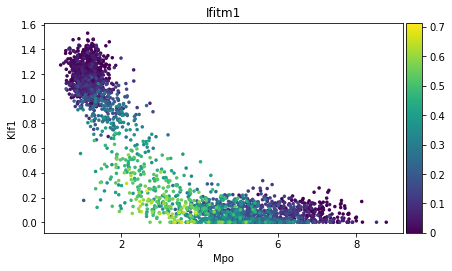

In [6]:
sc.pp.normalize_per_cell(denoised_adata)
sc.pp.sqrt(denoised_adata)
sc.pl.scatter(denoised_adata, x='Mpo', y='Klf1', color='Ifitm1', cmap = 'magma')

Optimal rank: 12


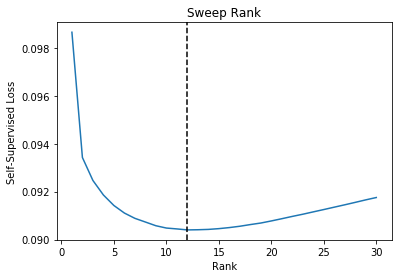

In [7]:
denoised_adata_pca = n2s_low_rank(paul, regression=False)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


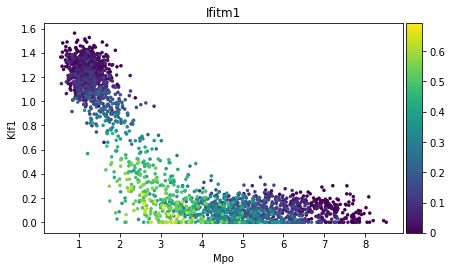

In [8]:
sc.pp.normalize_per_cell(denoised_adata_pca)
sc.pp.sqrt(denoised_adata_pca)
sc.pl.scatter(denoised_adata_pca, x='Mpo', y='Klf1', color='Ifitm1')

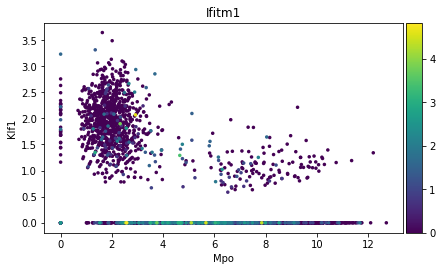

In [9]:
sc.pp.normalize_per_cell(paul)
sc.pp.sqrt(paul)
sc.pl.scatter(paul, x='Mpo', y='Klf1', color='Ifitm1')

In [10]:
denoised_adata.raw = denoised_adata

In [11]:
sc.pp.scale(denoised_adata)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


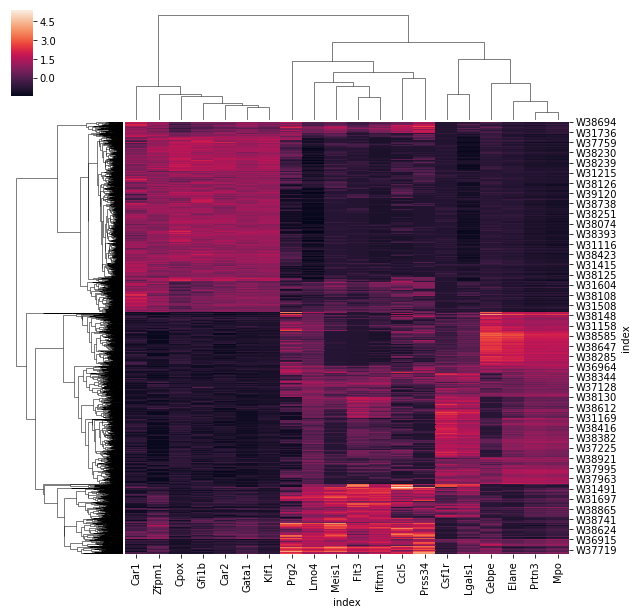

In [12]:
marker_genes = ['Ccl5', 'Prg2', 'Prss34', 'Meis1', 'Cebpe', 'Csf1r', 'Lgals1', 'Elane', 'Prtn3', 'Mpo',
                'Flt3', 'Ifitm1', 'Lmo4', 'Gata1', 'Gfi1b', 'Car1', 'Car2', 'Klf1', 'Zfpm1', 'Cpox']
clustergrid = sc.pl.clustermap(denoised_adata[:,marker_genes], use_raw = False, show = False)

## Plot vs raw in same order

In [13]:
denoised_inset = denoised_adata[:,marker_genes][clustergrid.dendrogram_row.reordered_ind,:][:, clustergrid.dendrogram_col.reordered_ind]

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


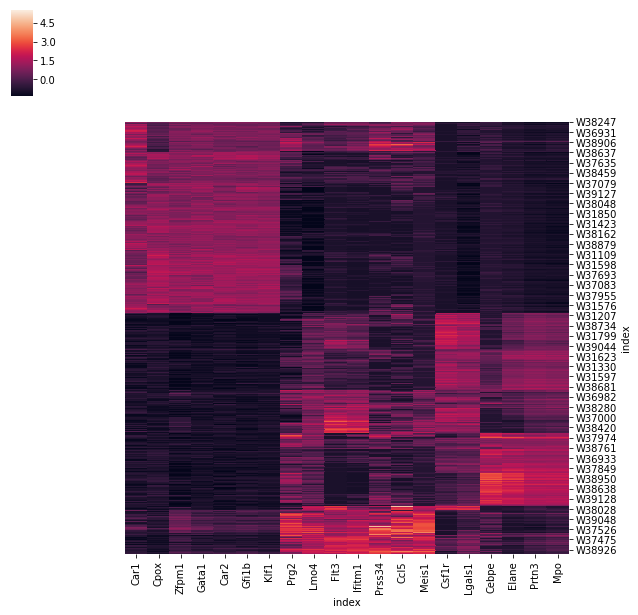

In [13]:
sc.pl.clustermap(denoised_inset, use_raw = False, row_cluster = False, col_cluster = False)

In [14]:
paul.raw = paul
sc.pp.normalize_per_cell(paul, counts_per_cell_after=1e4)
sc.pp.sqrt(paul)
sc.pp.scale(paul)

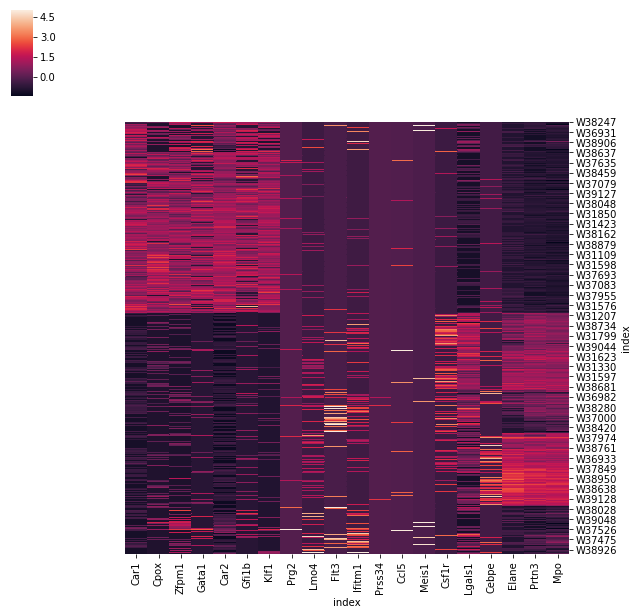

In [15]:
paul_inset = denoised_inset = paul[:,marker_genes][clustergrid.dendrogram_row.reordered_ind,:][:, clustergrid.dendrogram_col.reordered_ind]
sc.pl.clustermap(paul_inset, use_raw = False, row_cluster = False, col_cluster = False, vmax = 5)

# HCA

In [207]:
hca = sc.read('/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad')
hca_down = sc.pp.downsample_counts(hca, 2000, replace = False, copy = True)

Optimal rank: 10


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'int64' is maintained. 


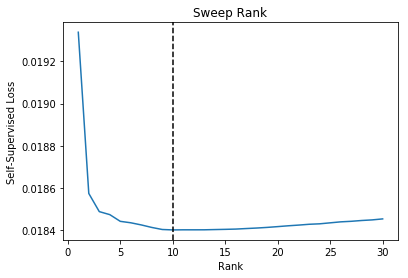

In [167]:
denoised_hca = n2s_low_rank(hca_down, regression=True)

Optimal rank: 9


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'int64' is maintained. 


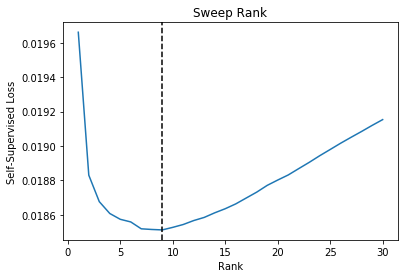

In [168]:
denoised_hca_pca = n2s_low_rank(hca_down, regression=False)

In [45]:
from scipy.sparse import issparse
def cor(X, Y):
    if issparse(X):
        X = np.array(X.todense())
    if issparse(Y):
        Y = np.array(Y.todense())
    return np.corrcoef(X.ravel(), Y.ravel())[0, 1]

In [27]:
print("Original correlation: ", cor(hca_down.X.sqrt(), hca.X.sqrt()))

Original correlation:  0.7802032108454697


In [29]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca.X), hca.X.sqrt()))

Denoised correlation:  0.897139371747421


In [30]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_pca.X), hca.X.sqrt()))

Denoised correlation:  0.8967855924920433


In [220]:
U, S, V = randomized_svd(np.sqrt(hca_down.X), 30)
denoised_hca_all = U.dot(np.diag(S)).dot(V)
denoised_hca_all = np.maximum(denoised_hca_all, 0)
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_all), hca.X.sqrt()))

Denoised correlation:  0.8691104247075322


In [174]:
from util import poisson_expected_sqrt
expected_sqrt = poisson_expected_sqrt(np.array(hca.X.todense())/np.array(hca.X.todense()).sum(axis = 1, keepdims = True)*2000, 30)

# Simulation

In [162]:
import pickle
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)

In [163]:
true_means = np.exp(exp.dot(programs))

In [164]:
model = LowRank()
best_rank, rank_range, losses = model.sweep(umis_X, umis_Y, 30)

Optimal rank: 3


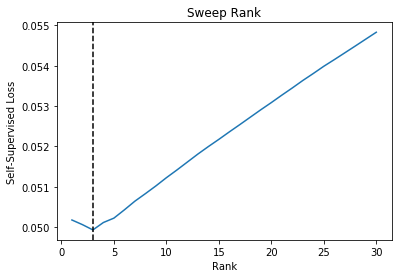

In [165]:
plt.plot(rank_range, losses)
plt.xlabel("Rank")
plt.ylabel("Self-Supervised Loss")
plt.title("Sweep Rank")
plt.axvline(best_rank, color="k", linestyle="--")

denoised = model.fit_transform(umis_X, umis_Y)

In [148]:
umis_X = paul.X

In [159]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(np.sqrt(umis_X), 9)

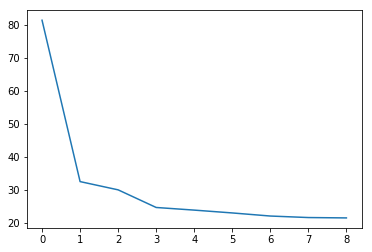

In [161]:
plt.plot(S)

(0, 1)

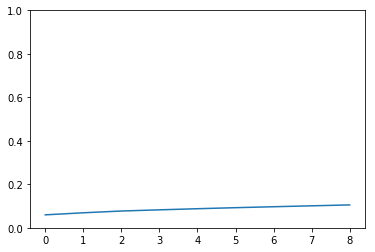

In [160]:
plt.plot((S*S).cumsum()/umis_X.sum())
plt.ylim(0,1)

In [137]:
denoised_sqrt = U.dot(np.diag(S)).dot(V)

In [139]:
denoised_sqrt = np.maximum(denoised_sqrt, 0)

In [133]:
correlation(denoised_sqrt.ravel(), np.sqrt(true_means).ravel())

ValueError: operands could not be broadcast together with shapes (26062511,) (2097152,) 

In [140]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.45  , 5567.8955, 4926.566 , ..., 3890.741 , 3409.2192,
       8071.7227], dtype=float32)

In [138]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.5254, 5568.3613, 4927.9585, ..., 3891.8545, 3409.6824,
       8071.7256], dtype=float32)

In [141]:
umis_X.sum(1)

array([ 4031.,  7741.,  7064., ...,  5689.,  5216., 10358.], dtype=float32)

In [55]:
from scipy.spatial.distance import correlation

In [73]:
(denoised*denoised).sum(), umis_X.sum()

(536.7738869945135, 111218)

In [56]:
correlation(np.sqrt(denoised).ravel(), np.sqrt(true_means).ravel())

0.37145616356605593

In [57]:
correlation(np.sqrt(umis_X).ravel(), np.sqrt(true_means).ravel())

0.8376143837983456

In [58]:
adata = sc.AnnData(X = umis_X)

In [ ]:
adata = 

# Stability of PC Regression

In [11]:
paul = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


Optimal rank: 16


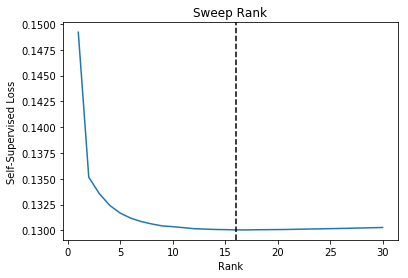

In [37]:
denoised_adata = n2s_low_rank(paul, regression=True)

In [ ]:
V = np.random.randn(500,5)
W = np.random.randn(5, 200)
L = (V.dot(W))
L = L/(np.max(L))*3

X1 = np.random.randn(V)
X2 = np.random.randn(W)

In [30]:
X = paul.X

X = X.astype(np.int)
np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

In [31]:
x = np.sqrt(denoised_adata.X)

In [36]:
rank_range = np.arange(1, 25, 2)
diff_from_opt = np.zeros(len(rank_range))
for i, r in enumerate(rank_range):
    model = LowRank(r, regression=True)
    y = model.fit_transform(X1, X2)
    diff = ((np.sqrt(y) - x)**2).mean()
    diff_from_opt[i] = diff
    print(r, ': ', diff)

1 :  0.02056164118959706
3 :  0.004906760324514881
5 :  0.0027534155659403267
7 :  0.0017187939439523943
9 :  0.001070357292043151
11 :  0.0006869342945542818
13 :  0.0003826122756931465
15 :  0.00018943817572063054
17 :  0.0002420149088303624
19 :  0.00037286476600429703
21 :  0.0005304636046424481
23 :  0.0006268238246982786


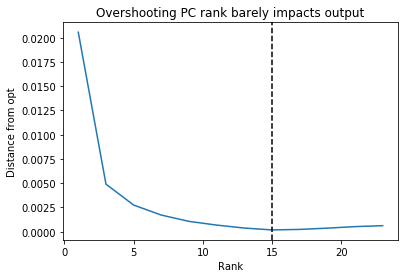

In [46]:
plt.plot(rank_range, diff_from_opt)
plt.xlabel("Rank")
plt.ylabel("Distance from opt")
plt.title("Overshooting PC rank barely impacts output")
plt.axvline(rank_range[np.argmin(diff_from_opt)], color='k', linestyle='--')

# Coefficients 

Given a matrix X which we write as $U S V$ and approximate as $U_r S_r V_r$, we may consider the PC regression to $Y$. That is,
we try to predict $Y$ from the feature matrix $X V_r^t S_r^{-1}= U_r$.

The regression map $W: \mathbb{R}^r \rightarrow \mathbb{R}^n$ is given by 

$W = U_r^t Y,$

since the feature matrix is orthogonal.

The weights for the $k^{th}$ PC are given by the $k^{th}$ row of that matrix. In particular, they do not depend on the choice of rank $r > k$.

(Note: there are two ways to view this. We may project the data $X$ orthogonally into PC space (in which case higher PCs will have low weight), or we may take it's coordinates in PC space (in which case all PCs will have equal weight). We choose the latter, since it shows that for the PCs with noisy values very little gets used. This is equivalent to dividing by $S_r$ after projection, which just shifts that term from $W$ over to the feature matrix.)

In [93]:
from scipy.sparse import issparse

X = paul.X
#X = hca_down.X

if issparse(X):
    X = np.array(X.todense())

X = X.astype(np.int)

np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

X1 = np.sqrt(X1)
X2 = np.sqrt(X2)

In [94]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X1, n_components=100, random_state=42)

In [95]:
W_pcr = U.T.dot(X2)
weight_norm_pcr = (W_pcr*W_pcr).sum(axis = 1)

W_pca = U.T.dot(X1)
weight_norm_pca = (W_pca*W_pca).sum(axis = 1)

The total norm of such coefficients is 1 if we use $X$ to regress $X$. When we are predicting $Y$, then the 
coefficients may drop off.

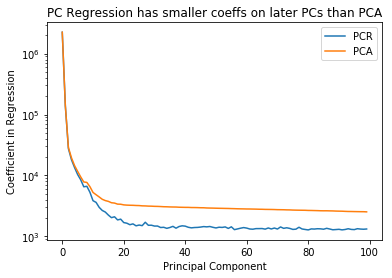

In [96]:
plt.plot(weight_norm_pcr, label = "PCR")
plt.plot(weight_norm_pca, label = "PCA")
plt.title("PC Regression has smaller coeffs on later PCs than PCA")
plt.xlabel("Principal Component")
plt.ylabel("Coefficient in Regression")
plt.yscale("log")
plt.legend()